## 作業

比較不同的 optimizer 與 learning rate 的組合對訓練的結果與影響，常見的 optimizer 包含：

* SGD
* RMSprop
* AdaGrad
* Adam

## 參考資料

常見優化器方法總結：

SGD (mini-batch)：在單步更新與全局更新的折衷辦法，通常搭配 momentum 穩定收斂方向與結果，收斂速度較慢。

RMSprop：學習率的調整是根據過去梯度的狀況調整，收斂速度快又不易會出現學習率快速下降的狀況。

Adam：同樣是可以根據過去的梯度自行調整學習率，但校正方式考量一、二階矩陣，使其更加平穩。

在實作過程中，建議先使用 Adam 驗證，若要做最終的優化，則再改用 SGD 找到最佳參數。

[优化器的用法](https://keras.io/zh/optimizers/)

[优化方法总结](https://blog.csdn.net/u010089444/article/details/76725843)

[An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
def train_models(X_train, y_train, X_test, y_test, epochs, batch_size, optimizer_clz, optimizer_param, learning_rates=()):
    train_histories = []
    for i, learning_rate in enumerate(learning_rates):
        print('Experiment with learning rate: {:.6f}'.format(learning_rate))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], 10, neuron_numbers=(512, 256, 128,))
        model.summary()
        model.compile(optimizer=optimizer_clz(**{**optimizer_param, 'lr': learning_rate}),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers=()):
    main_input, hidden_layer = Input(shape=input_shape, name='main_input'), None
    for i, neuron_number in enumerate(neuron_numbers):
        dense_layer = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')
        hidden_layer = dense_layer(hidden_layer) if hidden_layer is not None else dense_layer(main_input)
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_layer)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, learning_rates):
    plt.figure(figsize=(8, 6,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], learning_rates[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, learning_rate):
    plt.plot(train_history.history[train_name], '-', label='exp-lr-{:.1E}'.format(learning_rate), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp-lr-{:.1E}'.format(learning_rate), color=color)

## 使用 SGD 優化器在不同學習率下觀看學習曲線的走勢

In [7]:
## 設定超參數
epochs = 50
batch_size = 256
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
optimizer_clz = SGD
optimizer_param = {'momentum': 0.95, 'nesterov': True}

## 設定繪圖參數
colors = ['r', 'g', 'b', 'y', 'm']

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, epochs, batch_size,
                               optimizer_clz, optimizer_param, learning_rates=learning_rates)

Experiment with learning rate: 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 11s - loss: 2.1397 - acc: 0.

Epoch 22/50
 - 11s - loss: 0.9108 - acc: 0.6763 - val_loss: 1.4192 - val_acc: 0.5247
Epoch 23/50
 - 11s - loss: 0.8903 - acc: 0.6843 - val_loss: 1.4016 - val_acc: 0.5233
Epoch 24/50
 - 11s - loss: 0.8667 - acc: 0.6925 - val_loss: 1.4069 - val_acc: 0.5415
Epoch 25/50
 - 11s - loss: 0.8517 - acc: 0.6946 - val_loss: 1.3906 - val_acc: 0.5434
Epoch 26/50
 - 11s - loss: 0.8257 - acc: 0.7035 - val_loss: 1.4550 - val_acc: 0.5220
Epoch 27/50
 - 11s - loss: 0.8038 - acc: 0.7098 - val_loss: 1.4712 - val_acc: 0.5289
Epoch 28/50
 - 11s - loss: 0.7758 - acc: 0.7227 - val_loss: 1.5431 - val_acc: 0.5215
Epoch 29/50
 - 11s - loss: 0.7476 - acc: 0.7346 - val_loss: 1.4934 - val_acc: 0.5359
Epoch 30/50
 - 11s - loss: 0.7259 - acc: 0.7411 - val_loss: 1.5412 - val_acc: 0.5331
Epoch 31/50
 - 11s - loss: 0.7069 - acc: 0.7471 - val_loss: 1.5430 - val_acc: 0.5420
Epoch 32/50
 - 11s - loss: 0.6803 - acc: 0.7563 - val_loss: 1.5677 - val_acc: 0.5286
Epoch 33/50
 - 11s - loss: 0.6618 - acc: 0.7641 - val_loss: 1.638

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 11s - loss: 2.2612 - acc: 0.1701 - val_loss: 2.2004 - val_acc: 0.2117
Epoch 2/50
 - 11s - loss: 2.1540 - acc: 0.2418 - val_loss: 2.1084 - val_acc: 0.2707
Epoch 3/50
 - 11s - loss: 2.0734 - acc: 0.2795 - val_loss: 2.0386 - val_acc: 0.2912
Epoch 4/50
 - 11s - loss: 2.0114 - acc: 0.3027 - val_loss: 1.9830 - val_acc: 0.3105
Epoch 5/50
 - 11s - loss: 1.9625 - acc: 0.3198 - val_loss: 1.9411 - val_acc: 0.3286
Epoch 6/50
 - 11s - loss: 1.9259 - acc: 0.3313 - val_loss: 1.9105 - val_acc: 0.3324
Epoch 7/50
 - 11s - loss: 1.8975 - acc: 0.3389 - val_loss: 1.8850 - val_acc: 0.3389
Epoch 8/50
 - 11s - loss: 1.8746 - acc: 0.3463 - val_loss: 1.8652 - val_acc: 0.3497
Epoch 9/50
 - 11s - loss: 1.8544 - acc: 0.3538 - val_loss: 1.8466 - val_acc: 0.3549
Epoch 10/50
 - 11s - loss: 1.8382 - acc: 0.3590 - val_loss: 1.8324 - val_acc: 0.3564
Epoch 11/50
 - 10s - loss: 1.8230 - acc: 0.3645 - val_loss: 1.8194 - val_acc: 0.3600
Epoch 12/50
 - 11s - los

Epoch 35/50
 - 11s - loss: 1.9527 - acc: 0.3115 - val_loss: 1.9464 - val_acc: 0.3152
Epoch 36/50
 - 11s - loss: 1.9488 - acc: 0.3142 - val_loss: 1.9426 - val_acc: 0.3178
Epoch 37/50
 - 11s - loss: 1.9449 - acc: 0.3156 - val_loss: 1.9387 - val_acc: 0.3193
Epoch 38/50
 - 11s - loss: 1.9411 - acc: 0.3171 - val_loss: 1.9351 - val_acc: 0.3212
Epoch 39/50
 - 11s - loss: 1.9374 - acc: 0.3185 - val_loss: 1.9315 - val_acc: 0.3215
Epoch 40/50
 - 11s - loss: 1.9339 - acc: 0.3194 - val_loss: 1.9281 - val_acc: 0.3243
Epoch 41/50
 - 11s - loss: 1.9304 - acc: 0.3212 - val_loss: 1.9247 - val_acc: 0.3260
Epoch 42/50
 - 11s - loss: 1.9269 - acc: 0.3225 - val_loss: 1.9214 - val_acc: 0.3265
Epoch 43/50
 - 11s - loss: 1.9236 - acc: 0.3245 - val_loss: 1.9181 - val_acc: 0.3281
Epoch 44/50
 - 11s - loss: 1.9204 - acc: 0.3253 - val_loss: 1.9150 - val_acc: 0.3300
Epoch 45/50
 - 11s - loss: 1.9172 - acc: 0.3259 - val_loss: 1.9119 - val_acc: 0.3304
Epoch 46/50
 - 11s - loss: 1.9141 - acc: 0.3274 - val_loss: 1.908

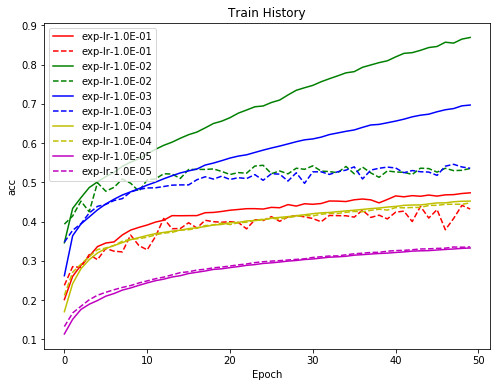

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, learning_rates)

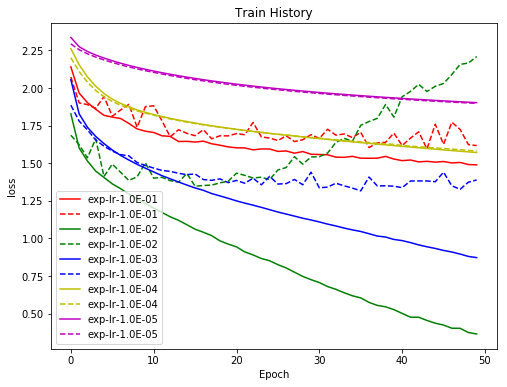

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, learning_rates)

## 使用 RMSprop 優化器在不同學習率下觀看學習曲線的走勢

In [11]:
## 設定超參數
epochs = 50
batch_size = 256
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
optimizer_clz = RMSprop
optimizer_param = {}

## 設定繪圖參數
colors = ['r', 'g', 'b', 'y', 'm']

In [12]:
train_histories = train_models(X_train, y_train, X_test, y_test, epochs, batch_size,
                               optimizer_clz, optimizer_param, learning_rates=learning_rates)

Experiment with learning rate: 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 13s - loss: 14.4457 - acc: 0

Epoch 21/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 22/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 23/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 24/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 25/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 26/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 27/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 28/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 29/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 30/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 31/50
 - 12s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 32/50
 - 12s - loss: 14.5063 - acc: 0

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 12s - loss: 1.9571 - acc: 0.2971 - val_loss: 1.8943 - val_acc: 0.3222
Epoch 2/50
 - 12s - loss: 1.7927 - acc: 0.3630 - val_loss: 1.8033 - val_acc: 0.3461
Epoch 3/50
 - 12s - loss: 1.7113 - acc: 0.3906 - val_loss: 1.6631 - val_acc: 0.4108
Epoch 4/50
 - 12s - loss: 1.6569 - acc: 0.4145 - val_loss: 1.6662 - val_acc: 0.4020
Epoch 5/50
 - 12s - loss: 1.6094 - acc: 0.4297 - val_loss: 1.6899 - val_acc: 0.4014
Epoch 6/50
 - 12s - loss: 1.5759 - acc: 0.4432 - val_loss: 1.6305 - val_acc: 0.4167
Epoch 7/50
 - 12s - loss: 1.5408 - acc: 0.4542 - val_loss: 1.5353 - val_acc: 0.4462
Epoch 8/50
 - 12s - loss: 1.5123 - acc: 0.4647 - val_loss: 1.5423 - val_acc: 0.4536
Epoch 9/50
 - 12s - loss: 1.4859 - acc: 0.4762 - val_loss: 1.5576 - val_acc: 0.4518
Epoch 10/50
 - 12s - loss: 1.4641 - acc: 0.4846 - val_loss: 1.5559 - val_acc: 0.4394
Epoch 11/50
 - 12s - loss: 1.4419 - acc: 0.4905 - val_loss: 1.5440 - val_acc: 0.4454
Epoch 12/50
 - 12s - los

Epoch 35/50
 - 12s - loss: 1.4789 - acc: 0.4854 - val_loss: 1.5241 - val_acc: 0.4617
Epoch 36/50
 - 12s - loss: 1.4729 - acc: 0.4874 - val_loss: 1.5125 - val_acc: 0.4692
Epoch 37/50
 - 12s - loss: 1.4676 - acc: 0.4895 - val_loss: 1.5024 - val_acc: 0.4748
Epoch 38/50
 - 12s - loss: 1.4629 - acc: 0.4922 - val_loss: 1.5079 - val_acc: 0.4694
Epoch 39/50
 - 12s - loss: 1.4573 - acc: 0.4931 - val_loss: 1.5043 - val_acc: 0.4715
Epoch 40/50
 - 12s - loss: 1.4531 - acc: 0.4947 - val_loss: 1.4963 - val_acc: 0.4742
Epoch 41/50
 - 12s - loss: 1.4477 - acc: 0.4965 - val_loss: 1.4986 - val_acc: 0.4746
Epoch 42/50
 - 12s - loss: 1.4425 - acc: 0.4979 - val_loss: 1.4895 - val_acc: 0.4813
Epoch 43/50
 - 12s - loss: 1.4381 - acc: 0.4989 - val_loss: 1.4888 - val_acc: 0.4759
Epoch 44/50
 - 12s - loss: 1.4334 - acc: 0.5015 - val_loss: 1.4883 - val_acc: 0.4781
Epoch 45/50
 - 12s - loss: 1.4282 - acc: 0.5025 - val_loss: 1.4801 - val_acc: 0.4806
Epoch 46/50
 - 12s - loss: 1.4237 - acc: 0.5051 - val_loss: 1.490

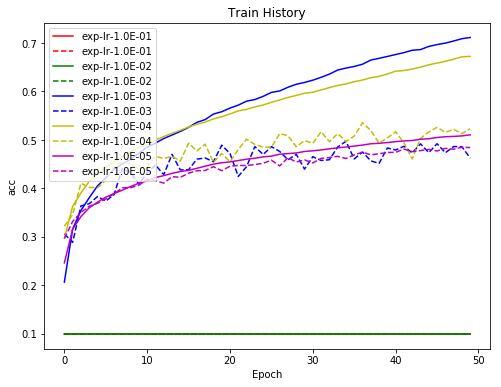

In [13]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, learning_rates)

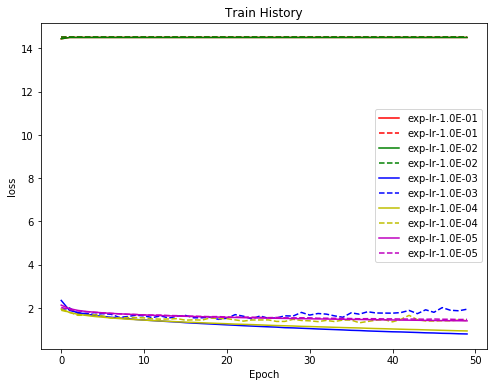

In [14]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, learning_rates)

## 使用 AdaGrad 優化器在不同學習率下觀看學習曲線的走勢

In [15]:
## 設定超參數
epochs = 50
batch_size = 256
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
optimizer_clz = Adagrad
optimizer_param = {}

## 設定繪圖參數
colors = ['r', 'g', 'b', 'y', 'm']

In [16]:
train_histories = train_models(X_train, y_train, X_test, y_test, epochs, batch_size,
                               optimizer_clz, optimizer_param, learning_rates=learning_rates)

Experiment with learning rate: 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 12s - loss: 14.4430 - acc: 0

Epoch 21/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 22/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 23/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 24/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 25/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 26/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 27/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 28/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 29/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 30/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 31/50
 - 11s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 32/50
 - 11s - loss: 14.5063 - acc: 0

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 12s - loss: 2.0693 - acc: 0.2776 - val_loss: 1.9821 - val_acc: 0.3119
Epoch 2/50
 - 11s - loss: 1.9421 - acc: 0.3288 - val_loss: 1.9250 - val_acc: 0.3229
Epoch 3/50
 - 11s - loss: 1.8940 - acc: 0.3437 - val_loss: 1.8850 - val_acc: 0.3460
Epoch 4/50
 - 11s - loss: 1.8655 - acc: 0.3547 - val_loss: 1.8631 - val_acc: 0.3513
Epoch 5/50
 - 11s - loss: 1.8452 - acc: 0.3614 - val_loss: 1.8444 - val_acc: 0.3532
Epoch 6/50
 - 11s - loss: 1.8294 - acc: 0.3658 - val_loss: 1.8297 - val_acc: 0.3631
Epoch 7/50
 - 11s - loss: 1.8161 - acc: 0.3714 - val_loss: 1.8192 - val_acc: 0.3698
Epoch 8/50
 - 11s - loss: 1.8052 - acc: 0.3750 - val_loss: 1.8096 - val_acc: 0.3723
Epoch 9/50
 - 11s - loss: 1.7957 - acc: 0.3776 - val_loss: 1.8005 - val_acc: 0.3742
Epoch 10/50
 - 11s - loss: 1.7870 - acc: 0.3816 - val_loss: 1.7930 - val_acc: 0.3745
Epoch 11/50
 - 11s - loss: 1.7794 - acc: 0.3843 - val_loss: 1.7857 - val_acc: 0.3783
Epoch 12/50
 - 11s - los

Epoch 35/50
 - 11s - loss: 2.0090 - acc: 0.3016 - val_loss: 2.0139 - val_acc: 0.3031
Epoch 36/50
 - 11s - loss: 2.0067 - acc: 0.3025 - val_loss: 2.0117 - val_acc: 0.3043
Epoch 37/50
 - 11s - loss: 2.0044 - acc: 0.3035 - val_loss: 2.0095 - val_acc: 0.3036
Epoch 38/50
 - 11s - loss: 2.0022 - acc: 0.3048 - val_loss: 2.0074 - val_acc: 0.3038
Epoch 39/50
 - 11s - loss: 2.0001 - acc: 0.3049 - val_loss: 2.0053 - val_acc: 0.3061
Epoch 40/50
 - 11s - loss: 1.9980 - acc: 0.3062 - val_loss: 2.0033 - val_acc: 0.3047
Epoch 41/50
 - 11s - loss: 1.9960 - acc: 0.3067 - val_loss: 2.0014 - val_acc: 0.3059
Epoch 42/50
 - 11s - loss: 1.9940 - acc: 0.3078 - val_loss: 1.9995 - val_acc: 0.3061
Epoch 43/50
 - 11s - loss: 1.9920 - acc: 0.3077 - val_loss: 1.9977 - val_acc: 0.3066
Epoch 44/50
 - 11s - loss: 1.9902 - acc: 0.3089 - val_loss: 1.9958 - val_acc: 0.3074
Epoch 45/50
 - 11s - loss: 1.9883 - acc: 0.3096 - val_loss: 1.9941 - val_acc: 0.3071
Epoch 46/50
 - 11s - loss: 1.9865 - acc: 0.3096 - val_loss: 1.992

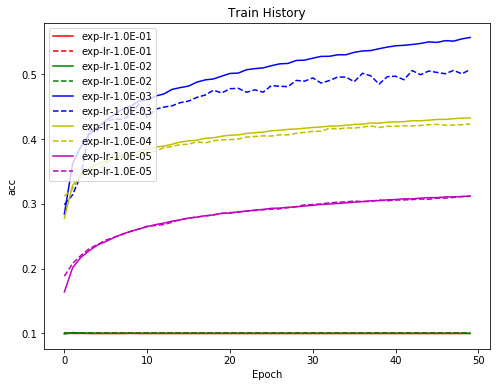

In [17]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, learning_rates)

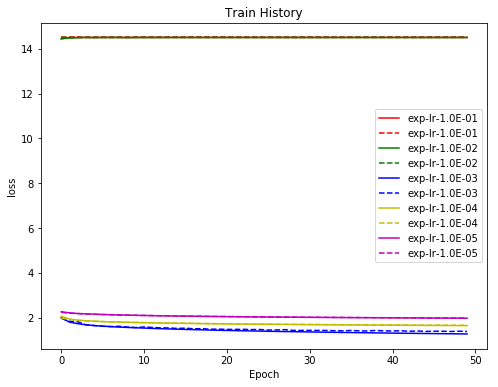

In [18]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, learning_rates)

## 使用 Adam 優化器在不同學習率下觀看學習曲線的走勢

In [19]:
## 設定超參數
epochs = 50
batch_size = 256
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
optimizer_clz = Adam
optimizer_param = {}

## 設定繪圖參數
colors = ['r', 'g', 'b', 'y', 'm']

In [20]:
train_histories = train_models(X_train, y_train, X_test, y_test, epochs, batch_size,
                               optimizer_clz, optimizer_param, learning_rates=learning_rates)

Experiment with learning rate: 0.100000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
main_output (Dense)          (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 15s - loss: 14.4450 - acc: 0

Epoch 21/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 22/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 23/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 24/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 25/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 26/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 27/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 28/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 29/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 30/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 31/50
 - 14s - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 32/50
 - 14s - loss: 14.5063 - acc: 0

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 15s - loss: 1.9091 - acc: 0.3209 - val_loss: 1.7677 - val_acc: 0.3749
Epoch 2/50
 - 14s - loss: 1.7178 - acc: 0.3947 - val_loss: 1.6807 - val_acc: 0.4017
Epoch 3/50
 - 14s - loss: 1.6341 - acc: 0.4226 - val_loss: 1.6017 - val_acc: 0.4298
Epoch 4/50
 - 14s - loss: 1.5762 - acc: 0.4456 - val_loss: 1.5933 - val_acc: 0.4260
Epoch 5/50
 - 14s - loss: 1.5302 - acc: 0.4618 - val_loss: 1.5407 - val_acc: 0.4577
Epoch 6/50
 - 14s - loss: 1.4942 - acc: 0.4746 - val_loss: 1.5035 - val_acc: 0.4688
Epoch 7/50
 - 14s - loss: 1.4597 - acc: 0.4855 - val_loss: 1.4779 - val_acc: 0.4704
Epoch 8/50
 - 14s - loss: 1.4345 - acc: 0.4948 - val_loss: 1.4632 - val_acc: 0.4811
Epoch 9/50
 - 14s - loss: 1.4106 - acc: 0.5050 - val_loss: 1.4592 - val_acc: 0.4812
Epoch 10/50
 - 14s - loss: 1.3807 - acc: 0.5150 - val_loss: 1.4307 - val_acc: 0.4961
Epoch 11/50
 - 14s - loss: 1.3674 - acc: 0.5191 - val_loss: 1.4152 - val_acc: 0.4959
Epoch 12/50
 - 14s - los

Epoch 35/50
 - 14s - loss: 1.4327 - acc: 0.5018 - val_loss: 1.4833 - val_acc: 0.4723
Epoch 36/50
 - 14s - loss: 1.4272 - acc: 0.5033 - val_loss: 1.4771 - val_acc: 0.4762
Epoch 37/50
 - 14s - loss: 1.4216 - acc: 0.5057 - val_loss: 1.4701 - val_acc: 0.4799
Epoch 38/50
 - 14s - loss: 1.4167 - acc: 0.5087 - val_loss: 1.4687 - val_acc: 0.4843
Epoch 39/50
 - 14s - loss: 1.4125 - acc: 0.5096 - val_loss: 1.4650 - val_acc: 0.4818
Epoch 40/50
 - 14s - loss: 1.4062 - acc: 0.5117 - val_loss: 1.4608 - val_acc: 0.4844
Epoch 41/50
 - 14s - loss: 1.4005 - acc: 0.5125 - val_loss: 1.4572 - val_acc: 0.4850
Epoch 42/50
 - 14s - loss: 1.3959 - acc: 0.5149 - val_loss: 1.4553 - val_acc: 0.4868
Epoch 43/50
 - 14s - loss: 1.3910 - acc: 0.5162 - val_loss: 1.4539 - val_acc: 0.4874
Epoch 44/50
 - 14s - loss: 1.3853 - acc: 0.5195 - val_loss: 1.4493 - val_acc: 0.4882
Epoch 45/50
 - 14s - loss: 1.3808 - acc: 0.5201 - val_loss: 1.4456 - val_acc: 0.4893
Epoch 46/50
 - 14s - loss: 1.3768 - acc: 0.5221 - val_loss: 1.440

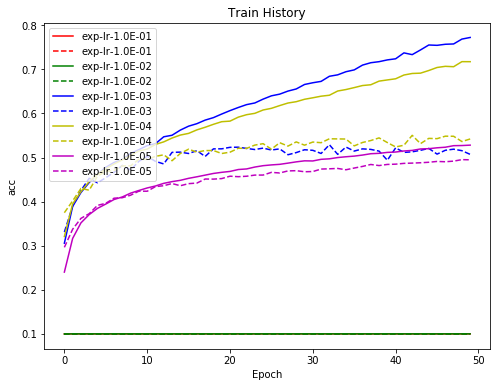

In [21]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, learning_rates)

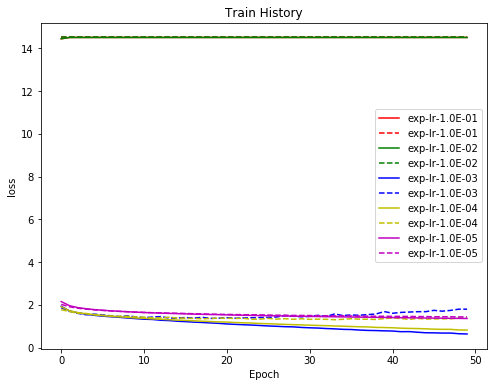

In [22]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, learning_rates)